In [1]:
# numerical / scientific
import numpy as np
import torch
import gpytorch as gp

# data
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)

# misc
import datetime
from typing import Tuple
from tqdm import tqdm

# utility imports
from utilities.processing_utility import get_q_2_cw_data 
from utilities.processing_utility import get_train_test_split, get_moving_average

from utilities.plotting_utility import plot_price_and_returns, plot_strategy_positions, plot_pnl

from utilities.strategy_utilities import *

from utilities.performance_utilities import sharpe_ratio, sortino_ratio, max_drawdown, calmar_ratio

# strategy imports

from strategies.ma_mean_reversion import get_ma_mean_reversion_signal


In [2]:
df = get_q_2_cw_data()

[*********************100%***********************]  1 of 1 completed


In [3]:
# get train test split
split_idx = int(len(df) * 0.7)
risk_free_rate_series = torch.tensor(df['daily_effr'].to_numpy(), dtype=torch.float32)
excess_return_data = torch.tensor(df['daily_excess_returns'].to_numpy(), dtype=torch.float32)
norm_excess_return_data = torch.tensor(df['normalised_excess_returns'].to_numpy(), dtype=torch.float32)
price_data = torch.tensor(df['adjusted_close_price'].to_numpy(), dtype=torch.float32)
x_data = torch.arange(0, len(price_data), dtype=torch.float32)

train_data, test_data = get_train_test_split(splitindex = split_idx, RFR = risk_free_rate_series, daily_R = excess_return_data, norm_R = norm_excess_return_data, P = price_data, X = x_data)

rfr_train, rfr_test = train_data['RFR'], test_data['RFR'] #  risk free rate
daily_r_train, daily_r_test = train_data['daily_R'], test_data['daily_R'] # daily excess returns
norm_r_train, norm_r_test = train_data['norm_R'], test_data['norm_R'] # normalised daily excess returns
p_train, p_test = train_data['P'], test_data['P'] # adjusted closing price
x_train, x_test = train_data['X'], test_data['X'] # x data

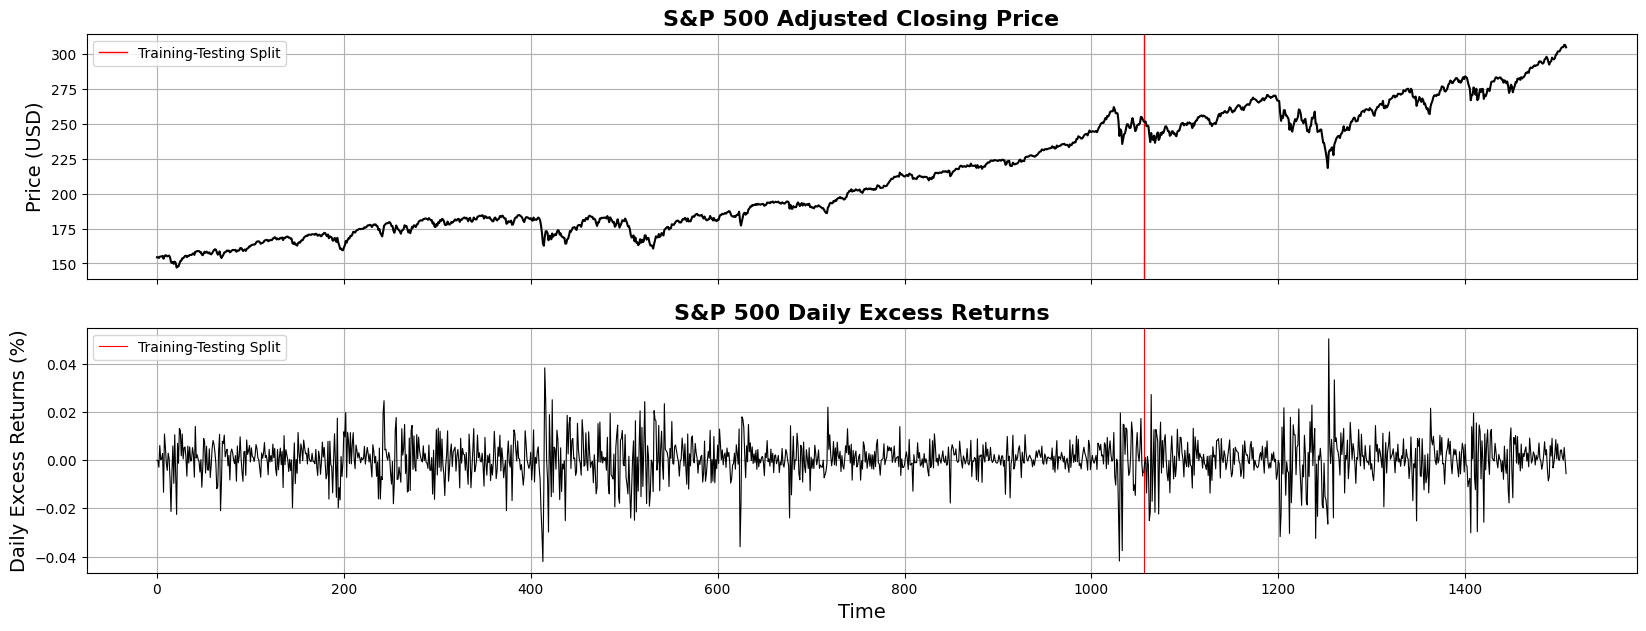

In [4]:
fig = plot_price_and_returns(x_train, p_train, daily_r_train, x_test, p_test, daily_r_test)

In [5]:
df

,adjusted_close_price,daily_effr,daily_returns,daily_excess_returns,normalised_excess_returns,risk_free_rate_factor
2014-01-02,154.400223,0.000003,0.000000,-0.000003,-0.054778,1.000003
2014-01-03,154.374908,0.000003,-0.000164,-0.000167,-0.074686,1.000003
2014-01-06,153.927567,0.000003,-0.002898,-0.002901,-0.406631,1.000003
2014-01-07,154.872925,0.000003,0.006142,0.006139,0.690994,1.000003
2014-01-08,154.906708,0.000003,0.000218,0.000215,-0.028244,1.000003
...,...,...,...,...,...,...
2019-12-23,305.051178,0.000062,0.001528,0.001466,0.123618,1.000062
2019-12-24,305.060669,0.000062,0.000031,-0.000030,-0.058083,1.000062
2019-12-26,306.684570,0.000062,0.005323,0.005262,0.584494,1.000062
2019-12-27,306.608612,0.000062,-0.000248,-0.000309,-0.091934,1.000062


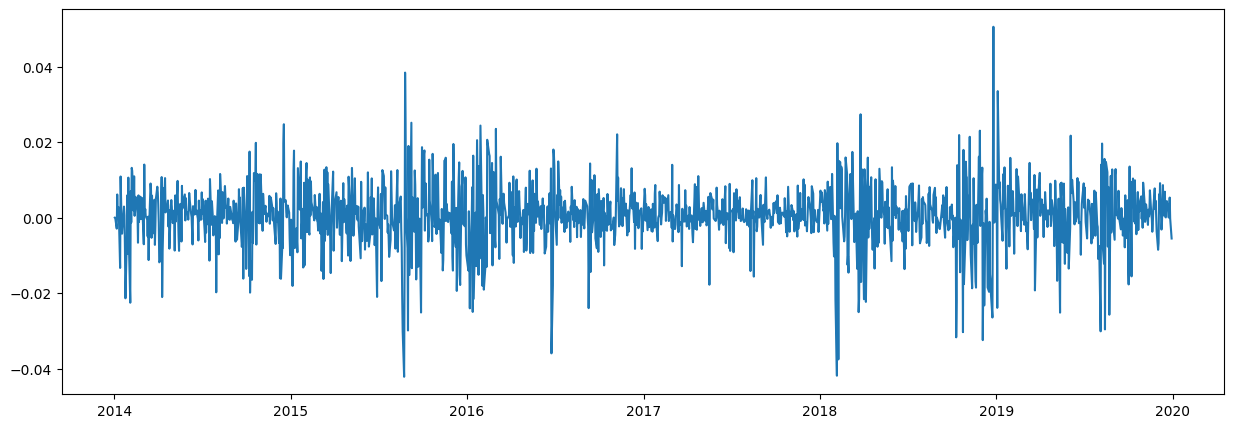

In [6]:
plt.plot(df.daily_returns)

NameError: name 'daily_returns' is not defined

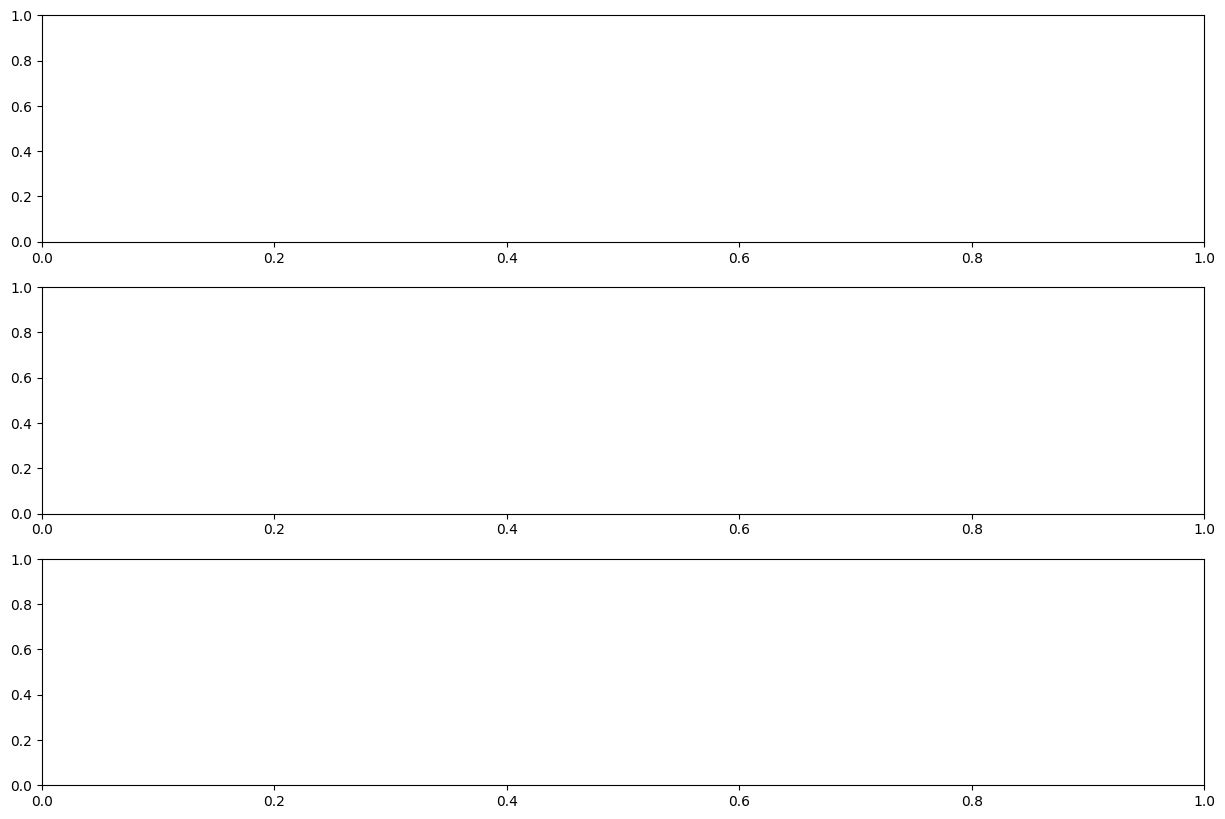

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

ax1.plot(x_train, daily_returns.daily_returns)
ax1.set_title('Price')

In [8]:
# get the strategy signals
train_signal = torch.ones_like(x_train)
test_signal = torch.ones_like(x_test)

In [9]:
# get dollar values and holdings
train_strategy_data = get_theta_and_V(daily_r_train, rfr_train , train_signal, initial_cash = 200_000., leverage = 5.)
test_strategy_data = get_theta_and_V(daily_r_test, rfr_test , test_signal, initial_cash = 200_000., leverage = 5.)

In [10]:
# unpack training data
train_theta = train_strategy_data['theta']
train_V_t = train_strategy_data['V_t']
train_delta_V_t = train_strategy_data['delta_V_t']
train_V_cap = train_strategy_data['V_cap']
train_delta_V_cap = train_strategy_data['delta_V_cap']
train_V_total = train_strategy_data['V_total']
train_delta_V_total = train_strategy_data['delta_V_total']

# unpack test data
test_theta = test_strategy_data['theta']
test_V_t = test_strategy_data['V_t']
test_delta_V_t = test_strategy_data['delta_V_t']
test_V_cap = test_strategy_data['V_cap']
test_delta_V_cap = test_strategy_data['delta_V_cap']
test_V_total = test_strategy_data['V_total']
test_delta_V_total = test_strategy_data['delta_V_total']

**(b). Plot the position of the strategies θt together with the upper and lower bounds $[−V_t \cdot L, V_t \cdot L]$.**


**Calculate the turnover in dollar value traded over time**

$$ \text{TurnoverDollars} = \sum_{t=0}^T |\Delta \theta_t| $$

**Additionally calculate the turnover in number of units traded over time**

$$ \text{TurnoverUnits} = \sum_{t=0}^T | \frac{\theta_{t+1}}{p_{t+1}} - \frac{\theta_t}{p_t} | $$

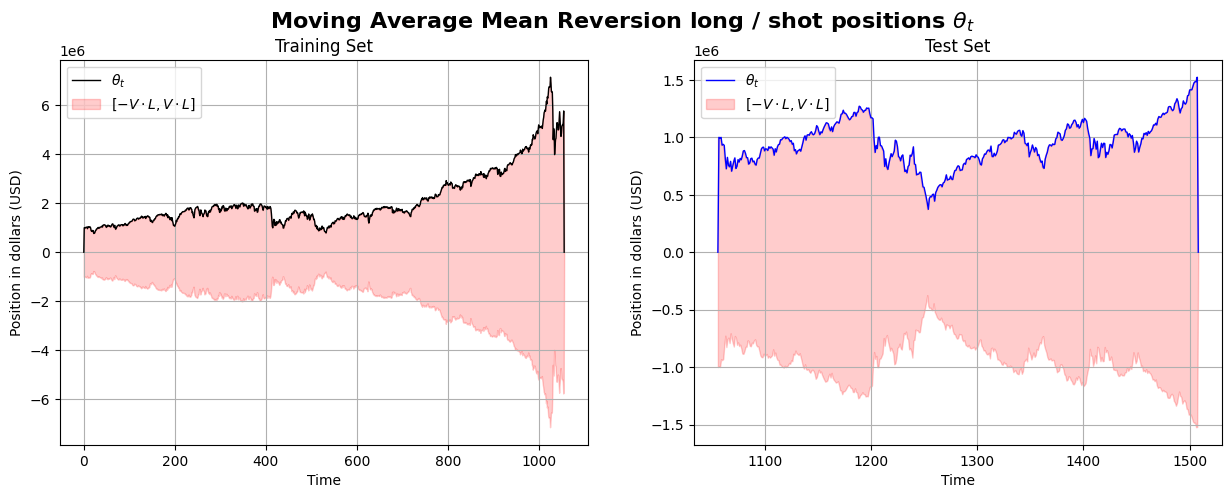

In [11]:
position_fig = plot_strategy_positions(
                    strategy_name = 'Moving Average Mean Reversion',
                    x_train = x_train,
                    train_theta = train_theta,
                    train_V_asset = train_V_t,
                    x_test = x_test,
                    test_theta = test_theta,
                    test_V_asset = test_V_t,)

In [13]:
print('Train Turnover Dollars: ', get_turnover_dollars(train_theta))
print('Train Turnover Units: ', get_turnover_units(train_theta, p_train))
print()
print('Test Turnover Dollars: ', get_turnover_dollars(test_theta))
print('Test Turnover Units: ', get_turnover_units(test_theta, p_test))

Train Turnover Dollars:  56972653.125
Train Turnover Units:  300251.9227482067

Test Turnover Dollars:  13267327.1875
Test Turnover Units:  52042.067287503276


**(c) Create a total PnL series for the strategies, where we assume that unused capital will be put in a money-market and grow at the same risk-free rate, i.e., the value of your account changes by the trading $PnL$, $(\Delta V)$ and the change in the growth of the money-market capital account $(\Delta V^{\text{cap}})$.**

$$ V_{t+1}^\text{total} -  V_{t}^\text{total} = \Delta V_t^\text{total}$$ 

$$ = \Delta V_t + \Delta V_t^\text{cap} $$

$$ = \left( \frac{\Delta p_t}{p_t} - r_t^f \right) \theta_t + \left( V_t^\text{total} - M_t \right)r_t^f $$

**where $M_t = \frac{|\theta_t|}{L}$ is the total margin used and $V_0$ was as above. Plot $\Delta V_t$ , $\Delta V_t^\text{cap}$, and $\Delta V_t^\text{total}$ and plot their accumulated values (i.e., cumsum() of each).**

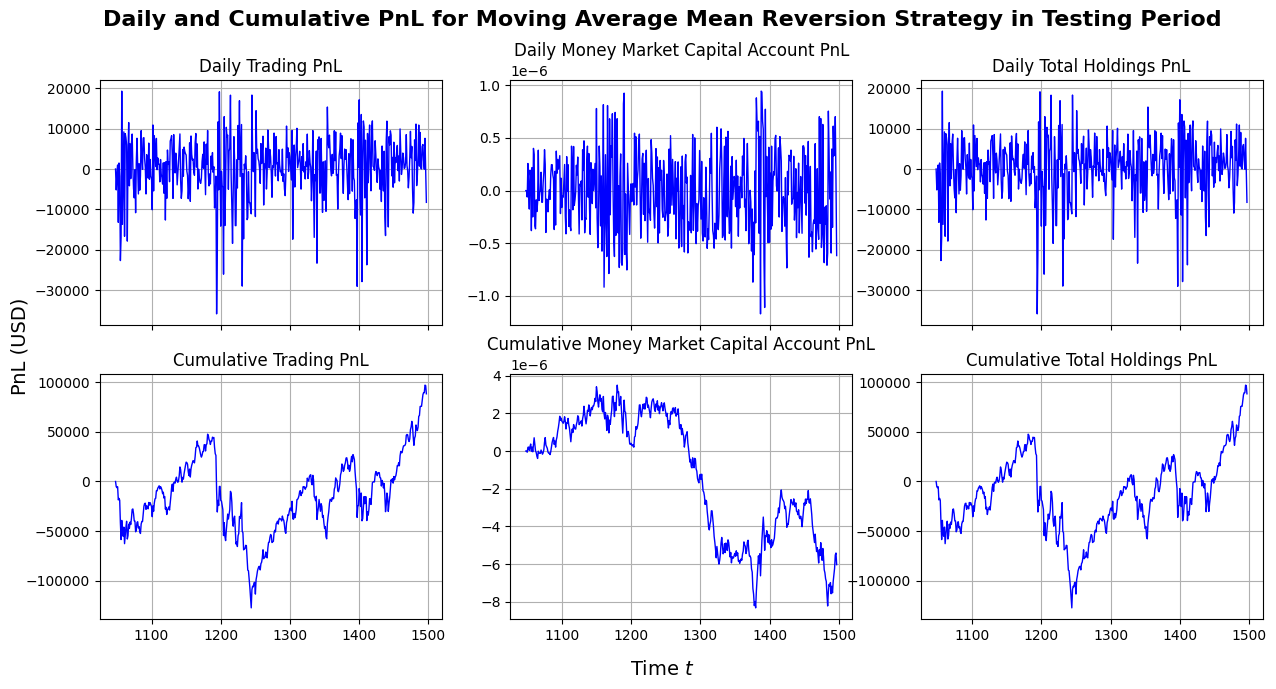

In [14]:
train_pnl_fig = plot_pnl(
    strategy_name = 'Moving Average Mean Reversion',    
    training_set=False,
    x = x_test,
    delta_V_asset = test_delta_V_t,
    delta_V_cap = test_delta_V_cap,
    delta_V_total = test_delta_V_total,)

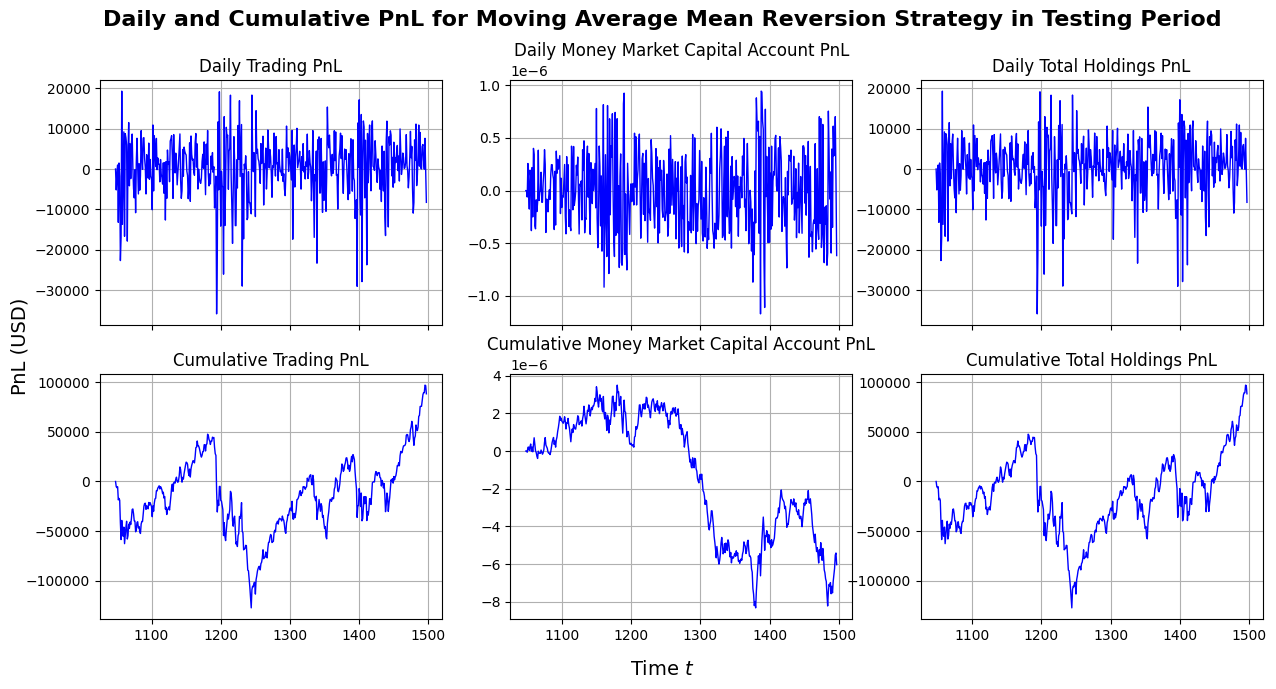

In [15]:
train_pnl_fig = plot_pnl(
    strategy_name = 'Moving Average Mean Reversion',    
    training_set=False,
    x = x_test,
    delta_V_asset = test_delta_V_t,
    delta_V_cap = test_delta_V_cap,
    delta_V_total = test_delta_V_total,)

# Performance Indicators

**(a) Define the excess return of a trading strategy as the daily trading $PnL$, $PnL_t = \Delta V_t$. Use this quantity to compute the Sharpe Ratio (SR), Sortino Ratio, Maximum Drawdown and the Calmar ratio of your strategies. For each of them provide two independent measurements: one within the training set and one within the test set.**

In [16]:
print('Train Sharpe Ratio: ', sharpe_ratio(train_delta_V_t))
print('Test Sharpe Ratio: ', sharpe_ratio(test_delta_V_t))

Train Sharpe Ratio:  1.5789447079937613
Test Sharpe Ratio:  0.5523273553285676


In [17]:
print('Train Sortino Ratio: ', sortino_ratio(train_delta_V_t))
print('Test Sortino Ratio: ', sortino_ratio(test_delta_V_t))

Train Sortino Ratio:  1.5964955391420514
Test Sortino Ratio:  0.6583105299664616


In [18]:
print('Train Max Drawdown: ', max_drawdown(train_delta_V_t, train_V_t))
print('Test Max Drawdown: ', max_drawdown(test_delta_V_t, test_V_t))

Train Max Drawdown:  -0.8115107619174164
Test Max Drawdown:  -0.7912404901117205


In [19]:
print('Train Calmar Ratio: ', calmar_ratio(train_delta_V_t, train_V_t))
print('Test Calmar Ratio: ', calmar_ratio(test_delta_V_t, test_V_t))

Train Calmar Ratio:  1.1174040893503505
Test Calmar Ratio:  -0.15112120622427214
